In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from psifr import fr
from itertools import product

from SR_MSweighted_v3 import Agent

In [2]:
df = fr.sample_data('Morton2013')
data = fr.merge_free_recall(df, study_keys=['category'])
data[(data.subject == 1) & (data.list==1) ]

,subject,list,item,input,output,study,recall,repeat,intrusion,category,prior_list,prior_input
0,1,1,TOWEL,1.0,13.0,True,True,0,False,obj,NaN,NaN
1,1,1,LADLE,2.0,NaN,True,False,0,False,obj,NaN,NaN
2,1,1,THERMOS,3.0,NaN,True,False,0,False,obj,NaN,NaN
3,1,1,LEGO,4.0,18.0,True,True,0,False,obj,NaN,NaN
4,1,1,BACKPACK,5.0,10.0,True,True,0,False,obj,NaN,NaN
5,1,1,JACKHAMMER,6.0,7.0,True,True,0,False,obj,NaN,NaN
6,1,1,LANTERN,7.0,NaN,True,False,0,False,obj,NaN,NaN
7,1,1,DOORKNOB,8.0,11.0,True,True,0,False,obj,NaN,NaN
8,1,1,SHOVEL,9.0,9.0,True,True,0,False,obj,NaN,NaN
9,1,1,SHOVEL,9.0,19.0,False,True,1,False,obj,NaN,NaN


In [3]:
crp = fr.lag_crp(data)
crp.head(10)

prob  actual  possible
subject lag                              
1       -23.0  0.020833       1        48
        -22.0  0.035714       3        84
        -21.0  0.026316       3       114
        -20.0  0.024000       3       125
        -19.0  0.014388       2       139
        -18.0  0.012195       2       164
        -17.0  0.044944       8       178
        -16.0  0.015707       3       191
        -15.0  0.049774      11       221
        -14.0  0.021645       5       231

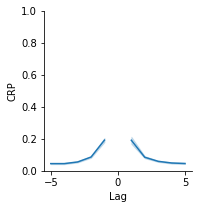

In [4]:
g = fr.plot_lag_crp(crp)

# let's test our model for the CRP effect


In [5]:
# Define parameters

params = {
    'alphas': [1, 0],
    'alpha_thresh': 0.0001,
    'c': -1,
    'recall_threshold': 1,
    'noise_std': 0.0003,
    'learning_rate': 0.3,  # learning rate for SR
    'decay_const': .5,  # eligibility trace decay parameter
    'discount': .5,
    'beta': .5,
    'decay_time': 1000  # number of time steps delay between learning and recall
}

n_sims = 500

In [6]:
# some example input words:
text_body = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z 1 2 3 4'
word_list = text_body.split()
sequence_length = len(word_list)
# associate each word with a unique state index:

word_list = pd.DataFrame({
    'item': word_list,
    'token': np.arange(len(word_list)),  # tokenization for the model (i.e. which state index corresponds to which word)
    'input': np.arange(len(word_list)) + 1
})


In [7]:
def write_simulation_output_to_df_for_psifr(all_recalled_words, word_list):
    # construct dataframe with all model results in the format required for psifr
    results_df = pd.concat([word_list] * n_sims)
    results_df['subject'] = np.repeat(np.arange(n_sims), len(word_list))
    results_df['recall'] = np.concatenate([np.isin(word_list.token, recall) for recall in all_recalled_words])  # recalled or not
    results_df['output'] = np.concatenate([[recall.index(tok) if tok in recall else np.nan for tok in word_list.token] for recall in all_recalled_words]) # position in recall for each word
    results_df['list'] = 1
    results_df['study'] = True
    return results_df


def simulate_learning_and_recall(word_list, n_sims, params):
    ag = Agent(len(word_list), learning_rate=params['learning_rate'], decay=params['decay_const'], discount=params['discount'], beta=params['beta'])
    p_stop = .05
    all_recalled_words = []

    for trial in range(n_sims):
        ag.reset()
        # learning over M does not accumulate across different trials (each trial is tested with free recall
        # individually) (this is because we're modelling each of these as a different run of the model / different subject).
        for t in word_list.token[:-1]:
            ag.update(t, t + 1)

        ag.SR_Ms[:, :, trial] = ag.Mcs

        for t in range(params['decay_time']):
            ag.decay_trace()

        recalled_words = ag.do_free_recall_sampling(p_stop, backward_sampling=False)
        all_recalled_words.append(recalled_words)
    return write_simulation_output_to_df_for_psifr(all_recalled_words, word_list)


results_df = simulate_learning_and_recall(word_list, n_sims, params)

In [8]:
crp = fr.lag_crp(results_df)

(0, 0.8)

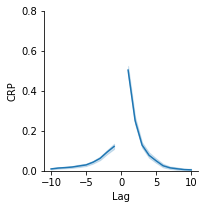

In [9]:
g = fr.plot_lag_crp(crp, max_lag=10)
plt.ylim([0, .8])

In [10]:
decay_params = [0, .25, .5, .75, 1.]  # rho
betas = [0, .25, .5, .75, 1.]

n_sims = 100

all_results = []
for beta, rho in product(betas, decay_params):
    params['discount'] = .5
    params['beta'] = beta
    params['decay_const'] = rho
    all_results.append(simulate_learning_and_recall(word_list, n_sims, params))

In [11]:
all_crp = []
for i, (beta, rho) in enumerate(product(betas, decay_params)):
    crp = fr.lag_crp(all_results[i])
    crp['beta'] = beta
    crp['trace_decay'] = rho
    all_crp.append(crp)
all_crp = pd.concat(all_crp)

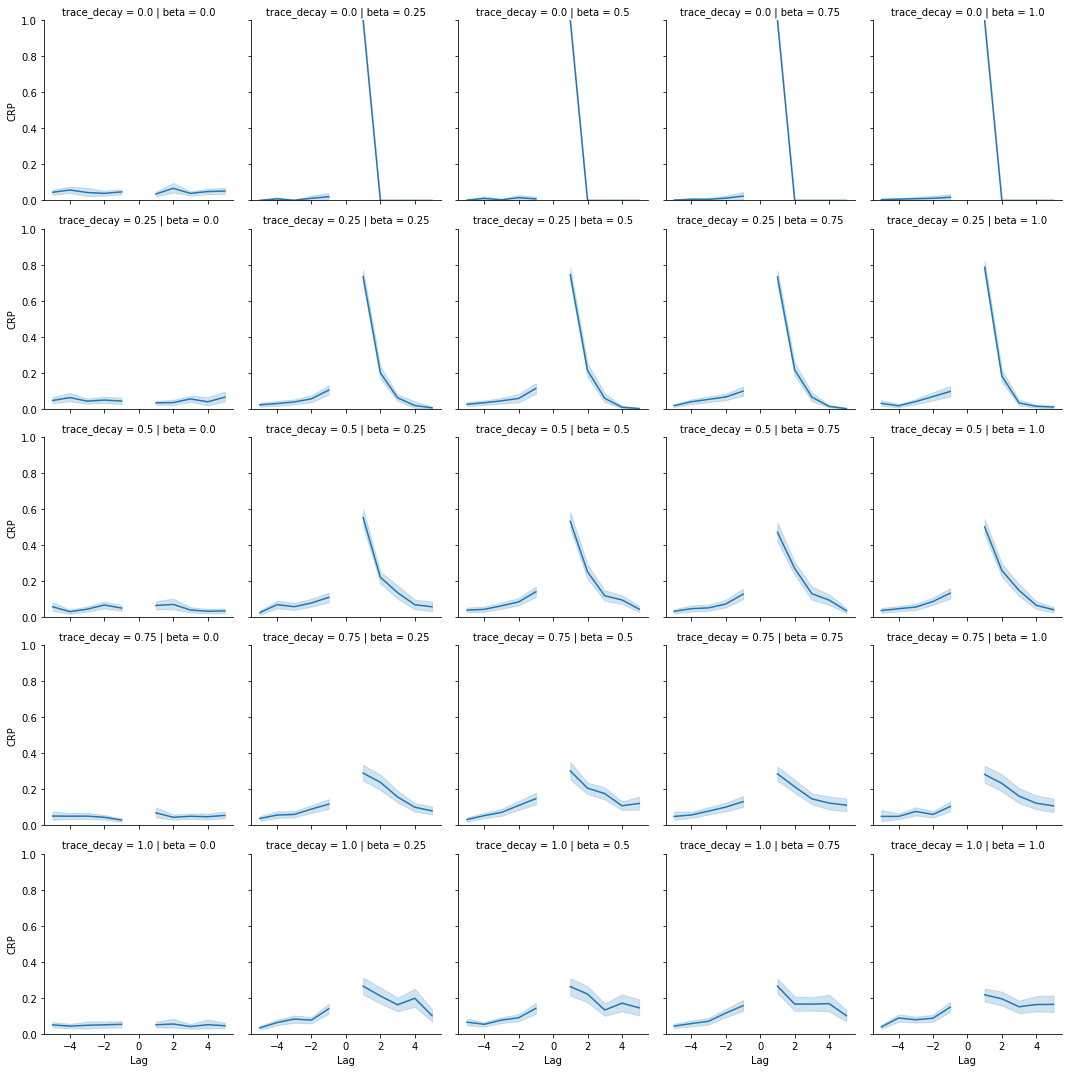

In [12]:
a = fr.plot_lag_crp(all_crp, col='beta', row='trace_decay')

## explanation for the reverse CRP effect:
- during retrieval, update the trace of the recently retrieved word with +1
- on next retrieval, we likely pick a word with small forward lag (because of SR)
- Let's say we pick a word with lag +2
- The word at lag 0 still has a sizeable entry in the trace vector.
- Thus, word at lag 1 is still more likely than chance to be chosen

Note, this assumes that:
- the trace doesn't decay too fast (i.e. trace_decay > 0), as can be seen above
- That the closer the discount factor of the original SR is to 1, the stronger this effect should be, because it only occurs when we "jump" past a word like in the example above.

Let's check that final assumption, below:

In [36]:
discount_factors = [0., .25, .5, .99]

results = []
for discount in discount_factors:
    params['discount'] = discount
    params['gamma'] = .5
    params['decay_const'] = .5
    results.append(simulate_learning_and_recall(word_list, n_sims, params))

all_crp = []
for i, discount in enumerate(discount_factors):
    crp = fr.lag_crp(results[i])
    crp['discount'] = discount
    all_crp.append(crp)
all_crp = pd.concat(all_crp)


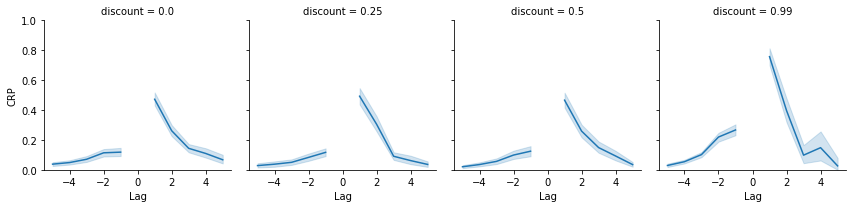

In [37]:
a = fr.plot_lag_crp(all_crp, col='discount')

As we can see the preceding CRP effect is stronger for larger discounts